# <B> Anormaly Detection based on AutoEncoder </B>
* Container: codna_pytorch_p39

## AutoEncoder based anomaly detection

- **RaPP** - Novelty Detection with Reconstruction along Projection Pathway <br>
<p align="center">
    <img src="imgs/rapp-f1.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>
<p align="center">
    <img src="imgs/rapp-f2.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>

    * [Ppaer, ICLR 2020] https://openreview.net/attachment?id=HkgeGeBYDB&name=original_pdf
    * [Desc, KOREAN] [RaPP](https://makinarocks.github.io/rapp/)
    * [Supplement #1] [Autoencoder based Anomaly Detection](https://makinarocks.github.io/Autoencoder-based-anomaly-detection/)
    * [Supplement #2] [Reference code (github)](https://github.com/Aiden-Jeon/RaPP)

## AutoReload

In [1]:
%load_ext autoreload
%autoreload 2

## parameter store 설정

In [2]:
import boto3
from utils.ssm import parameter_store

In [3]:
strRegionName=boto3.Session().region_name
pm = parameter_store(strRegionName)
prefix = pm.get_params(key="PREFIX")

## pramamters for tasks

In [4]:
account_id = pm.get_params(key="-".join([prefix, "ACCOUNT-ID"]))
defaulut_bucket = pm.get_params(key="-".join([prefix, "BUCKET"]))
sagemaker_role = pm.get_params(key="-".join([prefix, "SAGEMAKER-ROLE-ARN"]))
s3_data_path = pm.get_params(key="-".join([prefix, "S3-DATA-PATH"]))

In [5]:
print (f"prefix: {prefix}")
print (f"account_id: {account_id}")
print (f"defaulut_bucket: {defaulut_bucket}")
print (f"sagemaker_role: {sagemaker_role}")
print (f"s3_data_path: {s3_data_path}")

prefix: ad-ts
account_id: 419974056037
defaulut_bucket: sm-anomaly-detection
sagemaker_role: arn:aws:iam::419974056037:role/service-role/AmazonSageMaker-ExecutionRole-20221206T163436
s3_data_path: s3://sm-anomaly-detection/data


## 1. Data manipulation and visualization

In [6]:
import os
import pandas as pd
from utils.util import plot_click_w_fault_and_res, plot_click_w_fault_res_ad, plot_click_w_ad_exp

* load data and derive features

In [7]:
clicks_1T = pd.read_csv(os.path.join(s3_data_path, "clicks_1T.csv"), parse_dates=["timestamp"]).set_index("timestamp")
clicks_1T['residual'] = clicks_1T['click'] - clicks_1T['user'] 
clicks_1T['fault'] = pd.read_csv(os.path.join(s3_data_path, "fault_label_1T.csv"), header=None).values[0] ## label

In [8]:
print (f'data shape: {clicks_1T.shape}')
print (f'timestamp min: {clicks_1T.index.min()}, max: {clicks_1T.index.max()}')

data shape: (12960, 5)
timestamp min: 2020-07-07 00:00:00, max: 2020-07-15 23:59:00


* visualization

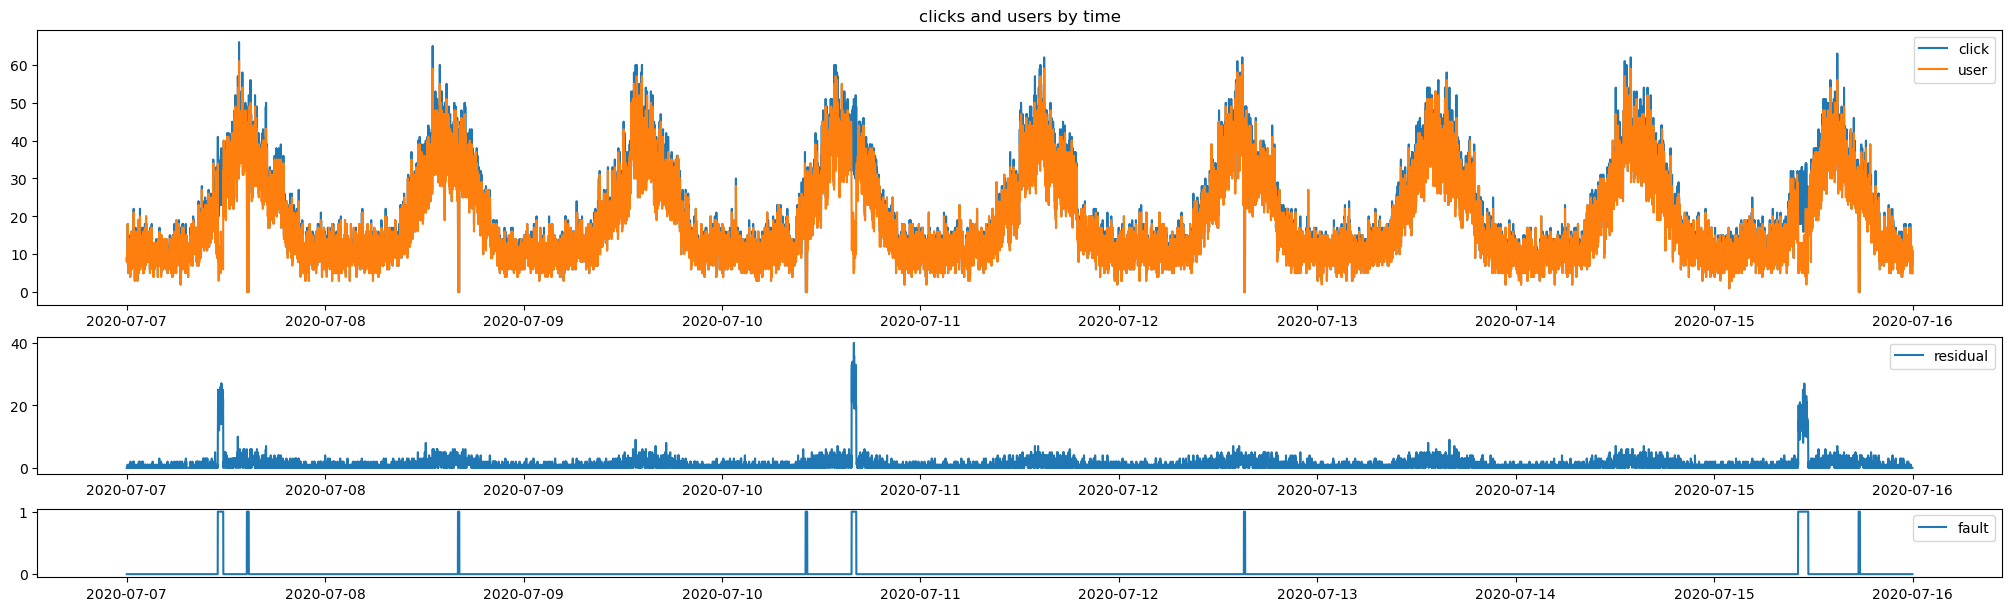

In [9]:
plot_click_w_fault_and_res(clicks_1T)

## 2. Preprocessing

* data split

In [10]:
train_data_ratio = 0.99

In [11]:
pdTrain = clicks_1T[["page", "user", "click", "residual", "fault"]][:int(clicks_1T.shape[0] * train_data_ratio)]
pdTest = clicks_1T[["page", "user", "click", "residual", "fault"]][int(clicks_1T.shape[0] * train_data_ratio):]
print (f"Train: {pdTrain.shape}, Test: {pdTest.shape}")

Train: (12830, 5), Test: (130, 5)


In [12]:
train_x, train_y = pdTrain[[strCol for strCol in pdTrain.columns if strCol != "fault"]].values, pdTrain["fault"].values.reshape(-1, 1)
test_x, test_y = pdTest[[strCol for strCol in pdTest.columns if strCol != "fault"]].values, pdTest["fault"].values.reshape(-1, 1)

In [13]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((12830, 4), (12830, 1), (130, 4), (130, 1))

* StandardScaler
    * Standardize features by removing the mean and scaling to unit variance

In [14]:
import pickle
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()

In [16]:
scaler.fit(train_x)

StandardScaler()

In [17]:
train_x_scaled = scaler.transform(train_x)
test_x_scaled = scaler.transform(test_x)

* dump scaler

In [18]:
with open(file="./dump/scaler.pkl", mode="wb") as f: pickle.dump(scaler, f)

In [19]:
#with open(file="./dump/scaler.pkl", mode="rb") as f: scaler=pickle.load(f)

* shingle

In [20]:
import numpy as np

In [21]:
def shingle(data, shingle_size=32):
    num_data, num_features = data.shape[0], data.shape[1]
    shingled_data = np.zeros((num_data-shingle_size+1, shingle_size*num_features))
    
    print (num_data, shingled_data.shape)
    
    for idx_feature in range(num_features):
        
        if idx_feature == 0:
            start, end = 0, shingle_size
        else:
            start = end
            end = start + shingle_size
                
        for n in range(num_data - shingle_size + 1):
            if n+shingle_size == num_data: shingled_data[n, start:end] = data[n:, idx_feature]    
            else: shingled_data[n, start:end] = data[n:(n+shingle_size), idx_feature]
                
    
    return shingled_data

In [22]:
shingle_size=4
train_x_scaled_shingle = shingle(train_x_scaled, shingle_size=shingle_size)
train_y_shingle = shingle(train_y, shingle_size=shingle_size)[:, -1].reshape(-1, 1)

print (f'train_x_scaled_shingle: {train_x_scaled_shingle.shape}')
print (f'train_y_shingle: {train_y_shingle.shape}')
print (f'check label: {sum(train_y_shingle == train_y[shingle_size-1:])}')
print (f'fault cnt, train_y_shingle: {sum(train_y_shingle)}, train_y: {sum(train_y[shingle_size-1:])}')

12830 (12827, 16)
12830 (12827, 4)
train_x_scaled_shingle: (12827, 16)
train_y_shingle: (12827, 1)
check label: [12827]
fault cnt, train_y_shingle: [203.], train_y: [203]


In [23]:
shingle_size=4
test_x_scaled_shingle = shingle(test_x_scaled, shingle_size=shingle_size)
test_y_shingle = shingle(test_y, shingle_size=shingle_size)[:, -1].reshape(-1, 1)

print (f'# features: {test_x_scaled.shape[1]}, shingle_size: {shingle_size}')
print (f'test_x_scaled_shingle: {test_x_scaled_shingle.shape}')
print (f'test_y_shingle: {test_y_shingle.shape}')
print (f'check label: {sum(test_y_shingle == test_y[shingle_size-1:])}')
print (f'fault cnt, train_y_shingle: {sum(test_y_shingle)}, train_y: {sum(test_y[shingle_size-1:])}')

130 (127, 16)
130 (127, 4)
# features: 4, shingle_size: 4
test_x_scaled_shingle: (127, 16)
test_y_shingle: (127, 1)
check label: [127]
fault cnt, train_y_shingle: [0.], train_y: [0]


## 3. AutoEncoder

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.metrics import f1_score

* gpu setting

In [25]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
        print("- Memory Usage:")
        print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
        print(f"  Cached:    {round(torch.cuda.memory_reserved(i)/1024**3,1)} GB\n")
        
else:
    print("# GPU is not available")
    
# GPU 할당 변경하기
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('# Current cuda device: ', torch.cuda.current_device()) # check

# DEVICE 0: Tesla V100-SXM2-16GB
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# Current cuda device:  0


* parameters for training

In [103]:
epoch = 300
batch_size = 128
lr = 1e-2

num_features = 4
shingle_size = shingle_size

* custom dataset and data loader

In [104]:
class CustomDataset(Dataset):
    
    def __init__(self, x, y):
        
        self.x, self.y = x, y

    def __len__(self):
        
        return len(self.x)

    def __getitem__(self, idx):
        
        x = torch.tensor(self.x[idx]).type(torch.float32)
        y = torch.tensor(self.y[idx]).type(torch.int)
        
        return x, y

* define dataset

In [105]:
train_ds = CustomDataset(
    x=train_x_scaled_shingle,
    y=train_y_shingle
)

test_ds = CustomDataset(
    x=test_x_scaled_shingle,
    y=test_y_shingle
)

* define dataloader

In [106]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_ds,
    batch_size = batch_size,
    shuffle = True,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    dataset = test_ds,
    batch_size = batch_size,
    shuffle = False,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    dataset = train_ds,
    batch_size = batch_size,
    shuffle = False,
    pin_memory=True
)

* define network architecture

In [107]:
class AutoEncoder(nn.Module):
    
    def __init__(self, input_dim):
        
        super(AutoEncoder, self).__init__()
        self.Encoder_1 = nn.Sequential(
            nn.Linear(input_dim,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU()
        )
        self.Encoder_2 = nn.Sequential(
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU()
        )
        
        self.Decoder = nn.Sequential(
            nn.Linear(32,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,input_dim),
        )
        
    def forward(self, x, hidden=False):
        
        if not hidden:
            x = self.Encoder_1(x)
            x = self.Encoder_2(x)
            x = self.Decoder(x)
            
            return x
        
        else:
            e1 = self.Encoder_1(x)
            e2 = self.Encoder_2(e1)
        
            return e1, e2

* define train class

In [108]:
class Trainer():
    
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device, epoch):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        self.epoch = epoch
        
        # Loss Function
        self.criterion = nn.L1Loss().to(self.device)
        self.anomaly_calculator = nn.L1Loss(reduction="none").to(self.device)
        
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        
    def fit(self, ):
        
        self.model.to(self.device)
        best_score = 0
        for epoch in range(self.epoch):
            self.model.train()
            train_loss = []
            for x, y in self.train_loader:
                x = x.to(self.device)
                
                self.optimizer.zero_grad()

                _x = self.model(x)
                loss = self.criterion(x, _x)
                
                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            
            if epoch % 10 == 0 :
                score = self.validation(self.model, 0.95)
                diff = self.cos(x, _x).cpu().tolist()
                print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}], Train cos : [{np.mean(diff)}] Val cos : [{score}])')

            if self.scheduler is not None:
                self.scheduler.step(score)

            if best_score < score:
                best_score = score
                torch.save(model.module.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
                
        return self.model
    
    def validation(self, eval_model, thr):
        
        eval_model.eval()
        with torch.no_grad():
            for x, y in self.val_loader:
                x, y= x.to(self.device), y.to(self.device)
                _x = self.model(x)
                anomal_score = self.anomaly_calculator(x, _x)
                diff = self.cos(x, _x).cpu().tolist()
                
        return np.mean(diff)
    
    def prediction(self, model, test_loader, num_features, shingle_size, feature_name):
        model.to(self.device)
        model.eval()
        
        anomal_scores = []
        with torch.no_grad():
            for x, y in test_loader:
                x, y= x.to(self.device), y.to(self.device)
                _x = model(x)
                e1, e2 = model(x, hidden=True)
                _e1, _e2 = model(_x, hidden=True)
                                
                anomal_score = self.anomaly_calculator(x, _x)
                sap_score = self.anomaly_calculator(x, _x).mean(dim=1) + self.anomaly_calculator(e1, _e1).mean(dim=1) + self.anomaly_calculator(e2, _e2).mean(dim=1)
                
                for record, fault, sap in zip(anomal_score.cpu().numpy(), y.cpu().numpy(), sap_score.cpu().numpy()):
                    dicScore = {"fault": fault[0], "ANOMALY_SCORE_SAP": sap}
                    for cnt, idx in enumerate(range(0, shingle_size*num_features, shingle_size)):
                        start = idx
                        end = start + shingle_size
                        dicScore[feature_name[cnt] + "_ATTRIBUTION_SCORE"] = np.mean(record[start:end])
                    
                    total_socre = 0
                    for k, v in dicScore.items():
                        if k not in ["fault", "ANOMALY_SCORE_SAP"]: total_socre += v
                    dicScore["ANOMALY_SCORE"] = total_socre
                    anomal_scores.append(dicScore)
                            
        return pd.DataFrame(anomal_scores)
                

In [109]:
model = nn.DataParallel(
    AutoEncoder(
        input_dim=num_features*shingle_size
    )
)

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=lr
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor=0.5,
    patience=10,
    threshold_mode='abs',
    min_lr=1e-8,
    verbose=True
)

In [110]:
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=scheduler,
    device=device,
    epoch=epoch
)

In [111]:
model = trainer.fit()

Epoch : [0] Train loss : [0.2285045848624541], Train cos : [0.8896213725761131] Val cos : [0.9835202079119645])
Epoch : [10] Train loss : [0.10273393450102003], Train cos : [0.9784355781696461] Val cos : [0.9930103041055635])
Epoch : [20] Train loss : [0.10005432972223452], Train cos : [0.9705012815969961] Val cos : [0.9957833909612941])
Epoch : [30] Train loss : [0.09475197742628579], Train cos : [0.9844410287009345] Val cos : [0.9977456838127197])
Epoch : [40] Train loss : [0.08577766487061388], Train cos : [0.9813718795776367] Val cos : [0.9984289360797312])
Epoch : [50] Train loss : [0.07828761047065848], Train cos : [0.9841807904066863] Val cos : [0.9987528868547575])
Epoch : [60] Train loss : [0.08007695404167223], Train cos : [0.988539801703559] Val cos : [0.9984782868482935])
Epoch 00062: reducing learning rate of group 0 to 5.0000e-03.
Epoch : [70] Train loss : [0.0687869255716848], Train cos : [0.9787655914271319] Val cos : [0.9992071089782114])
Epoch : [80] Train loss : [0.0

In [112]:
feature_name = ["URLS", "USERS", "CLICKS", "RESIDUALS"]
pdScores = trainer.prediction(model, test_loader, num_features, shingle_size, feature_name)

In [113]:
pdScores.index = pdTrain.iloc[shingle_size-1:, :].index
pdScores = pd.concat([pdScores, pdTrain.iloc[shingle_size-1:, :].drop(columns='fault')], axis=1).rename(columns={"page":"url"})

In [114]:
pdScores

,fault,ANOMALY_SCORE_SAP,URLS_ATTRIBUTION_SCORE,USERS_ATTRIBUTION_SCORE,CLICKS_ATTRIBUTION_SCORE,RESIDUALS_ATTRIBUTION_SCORE,ANOMALY_SCORE,url,user,click,residual
timestamp,,,,,,,,,,,
2020-07-07 00:03:00,0,0.041367,0.017891,0.015171,0.015703,0.005154,0.053920,6,11,11,0
2020-07-07 00:04:00,0,0.031193,0.008521,0.013137,0.013678,0.004684,0.040021,4,9,9,0
2020-07-07 00:05:00,0,0.036153,0.015786,0.013006,0.013878,0.005858,0.048527,5,9,9,0
2020-07-07 00:06:00,0,0.021950,0.006739,0.008193,0.008375,0.005201,0.028508,6,14,15,1
2020-07-07 00:07:00,0,0.043205,0.017021,0.017219,0.016699,0.008615,0.059554,7,18,18,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-15 21:45:00,0,0.044238,0.008355,0.016482,0.013881,0.023265,0.061984,8,12,12,0
2020-07-15 21:46:00,0,0.023457,0.010858,0.004400,0.002923,0.016274,0.034455,5,17,17,0
2020-07-15 21:47:00,0,0.030136,0.010169,0.008498,0.010414,0.012628,0.041708,8,12,14,2


## 4. Plotting the Prediction

Plot the anomalous points detected by AE.

###  - For Reconstruction Error

* Check the distribution of our anomaly score.

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

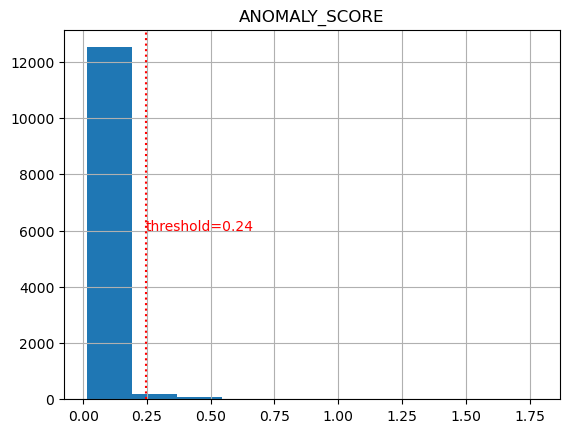

3 sigma threshoud = 0.2448144964710291


In [116]:
threshold_re = pdScores['ANOMALY_SCORE'].mean() + 2.5*pdScores['ANOMALY_SCORE'].std()

pdPlot = pd.DataFrame(pdScores['ANOMALY_SCORE'])
pdPlot.hist()
plt.axvline(x=threshold_re, linestyle=':', c='r')
plt.annotate('threshold={}'.format(round(threshold_re,2)), xy=(threshold_re,6000), color='r')
plt.show()

print('3 sigma threshoud = {}'.format(threshold_re))

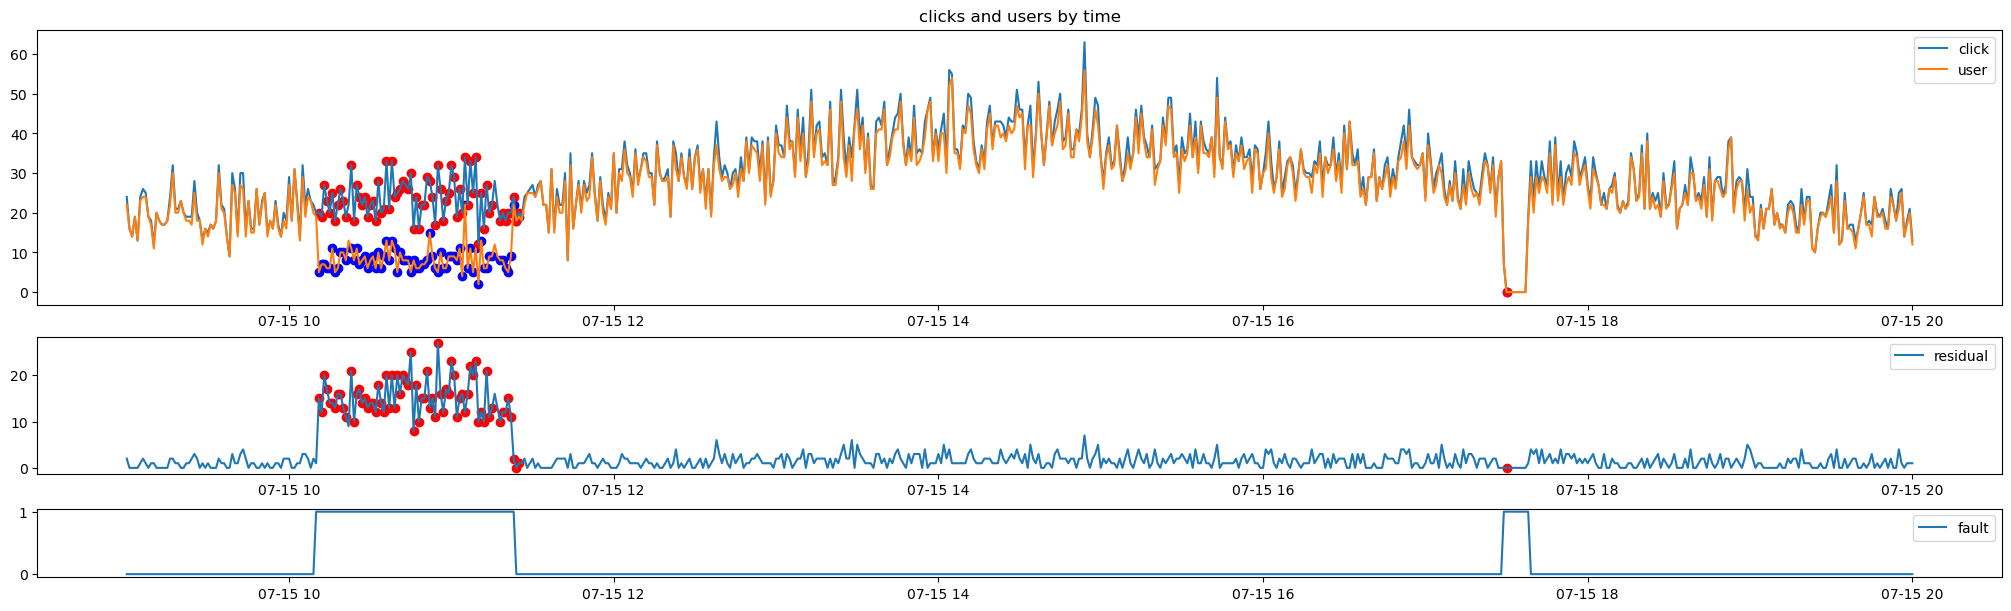

In [117]:
anomalous = pdScores.query("ANOMALY_SCORE > @threshold_re")
stime = "2020-07-15 09:00:00" # "2012-03-13 08:00:00"
etime = "2020-07-15 20:00:00" # "2012-03-13 20:00:00"
plot_click_w_fault_res_ad(pdScores, anomalous, threshold_re, start_dt=stime, end_dt=etime)

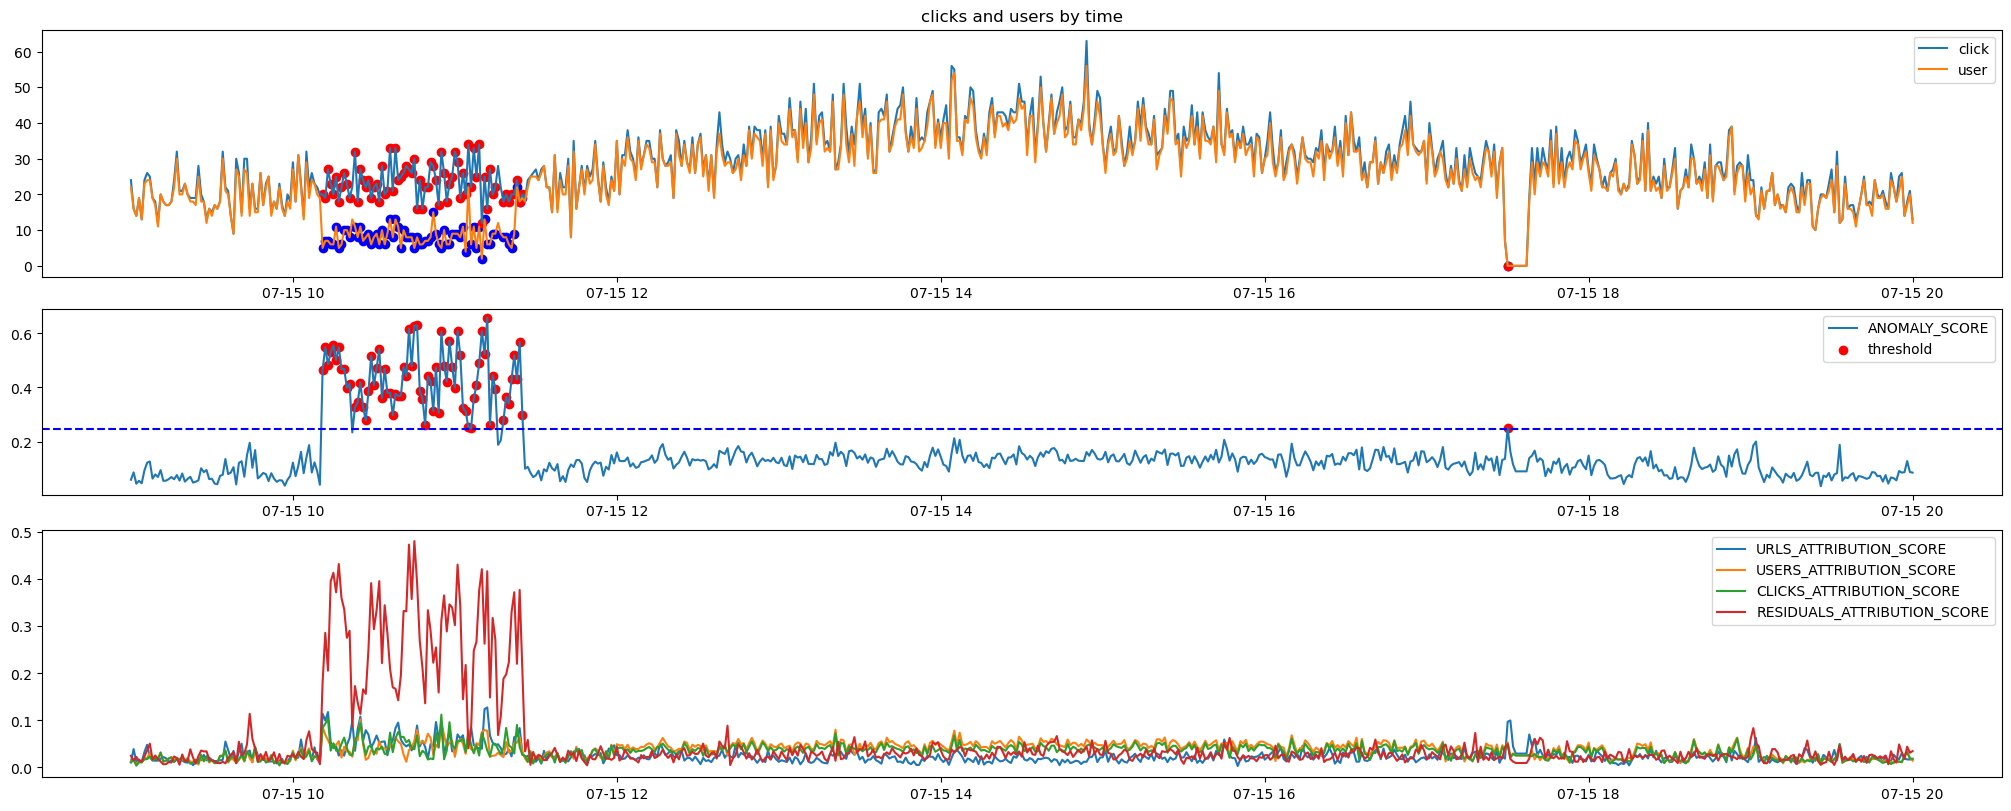

In [118]:
plot_click_w_ad_exp(pdScores, anomalous, threshold_re, start_dt=stime, end_dt=etime)

In [119]:
pdAnomal = pdScores.query("ANOMALY_SCORE > @threshold_re")[["ANOMALY_SCORE", "URLS_ATTRIBUTION_SCORE", "USERS_ATTRIBUTION_SCORE", \
                                                         "CLICKS_ATTRIBUTION_SCORE", "RESIDUALS_ATTRIBUTION_SCORE", "ANOMALY_SCORE_SAP"]] 

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


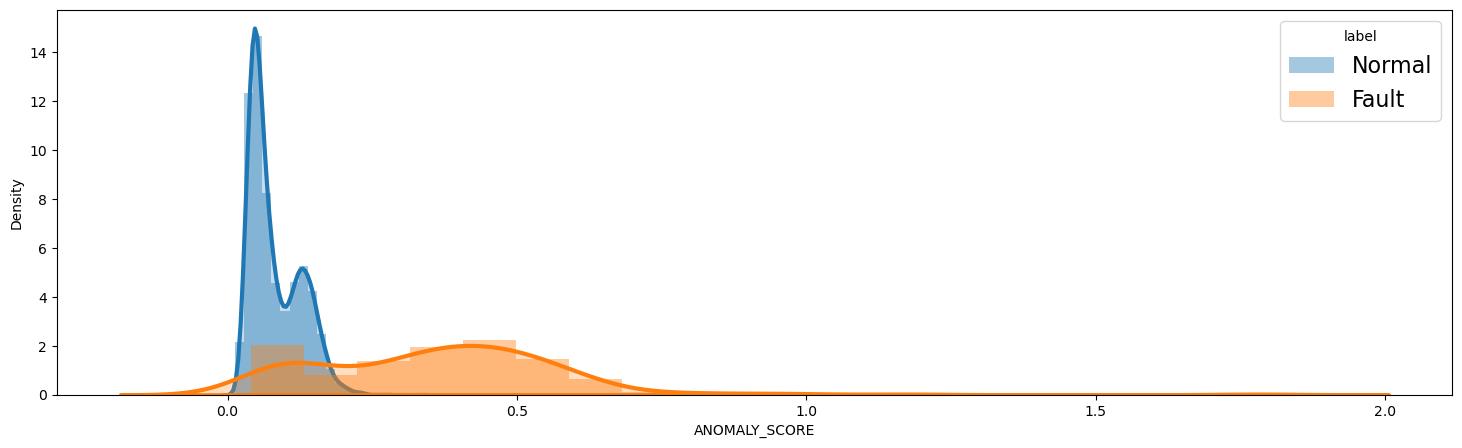

In [120]:
plt.figure(figsize = (18,5))
fault_types = [0, 1]
for fault_type in fault_types:
    
    if fault_type == 0: label = "Normal"
    else: label = "Fault"
    sns.distplot(
        pdScores[pdScores.fault==fault_type]["ANOMALY_SCORE"],
        hist=True,
        kde=True,
        kde_kws={"shade":True, "linewidth":3},
        label=label
    )
plt.legend(prop={"size":16}, title = "label")

* performance metric

In [131]:
precision = pdScores.query("fault == 1 and ANOMALY_SCORE > @threshold_re").shape[0] / pdScores.query("ANOMALY_SCORE > @threshold_re").shape[0]
recall = pdScores.query("fault == 1 and ANOMALY_SCORE > @threshold_re").shape[0] / pdScores.query("fault == 1").shape[0]
f1_score = 2*(precision*recall)/(precision+recall)

In [132]:
print (f'Precision: {precision}')
print (f'Recall: {recall}')
print (f'f1_score: {f1_score}')

Precision: 0.8802395209580839
Recall: 0.7241379310344828
f1_score: 0.7945945945945946


###  - For SAP Score

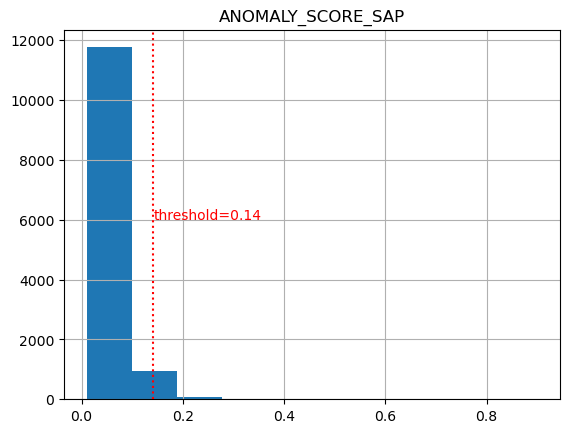

3 sigma threshoud = 0.14194964617490768


In [133]:
threshold_sap = pdScores['ANOMALY_SCORE_SAP'].mean() + 2.5*pdScores['ANOMALY_SCORE_SAP'].std()

pdPlot = pd.DataFrame(pdScores['ANOMALY_SCORE_SAP'])
pdPlot.hist()
plt.axvline(x=threshold_sap, linestyle=':', c='r')
plt.annotate('threshold={}'.format(round(threshold_sap,2)), xy=(threshold_sap,6000), color='r')
plt.show()

print('3 sigma threshoud = {}'.format(threshold_sap))

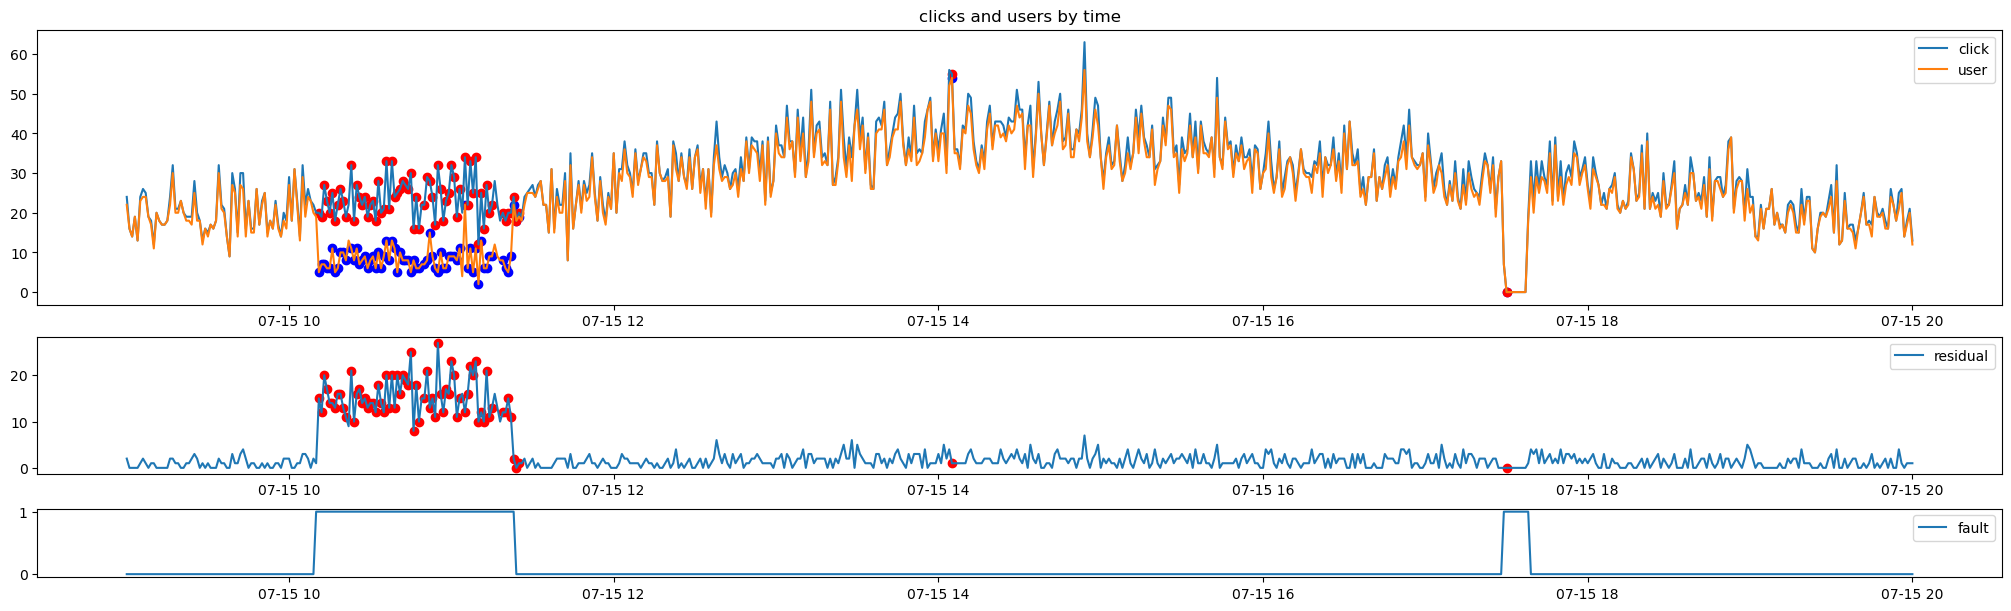

In [134]:
anomalous = pdScores.query("ANOMALY_SCORE_SAP > @threshold_sap")
stime = "2020-07-15 09:00:00" # "2012-03-13 08:00:00"
etime = "2020-07-15 20:00:00" # "2012-03-13 20:00:00"
plot_click_w_fault_res_ad(pdScores, anomalous, threshold_sap, start_dt=stime, end_dt=etime)

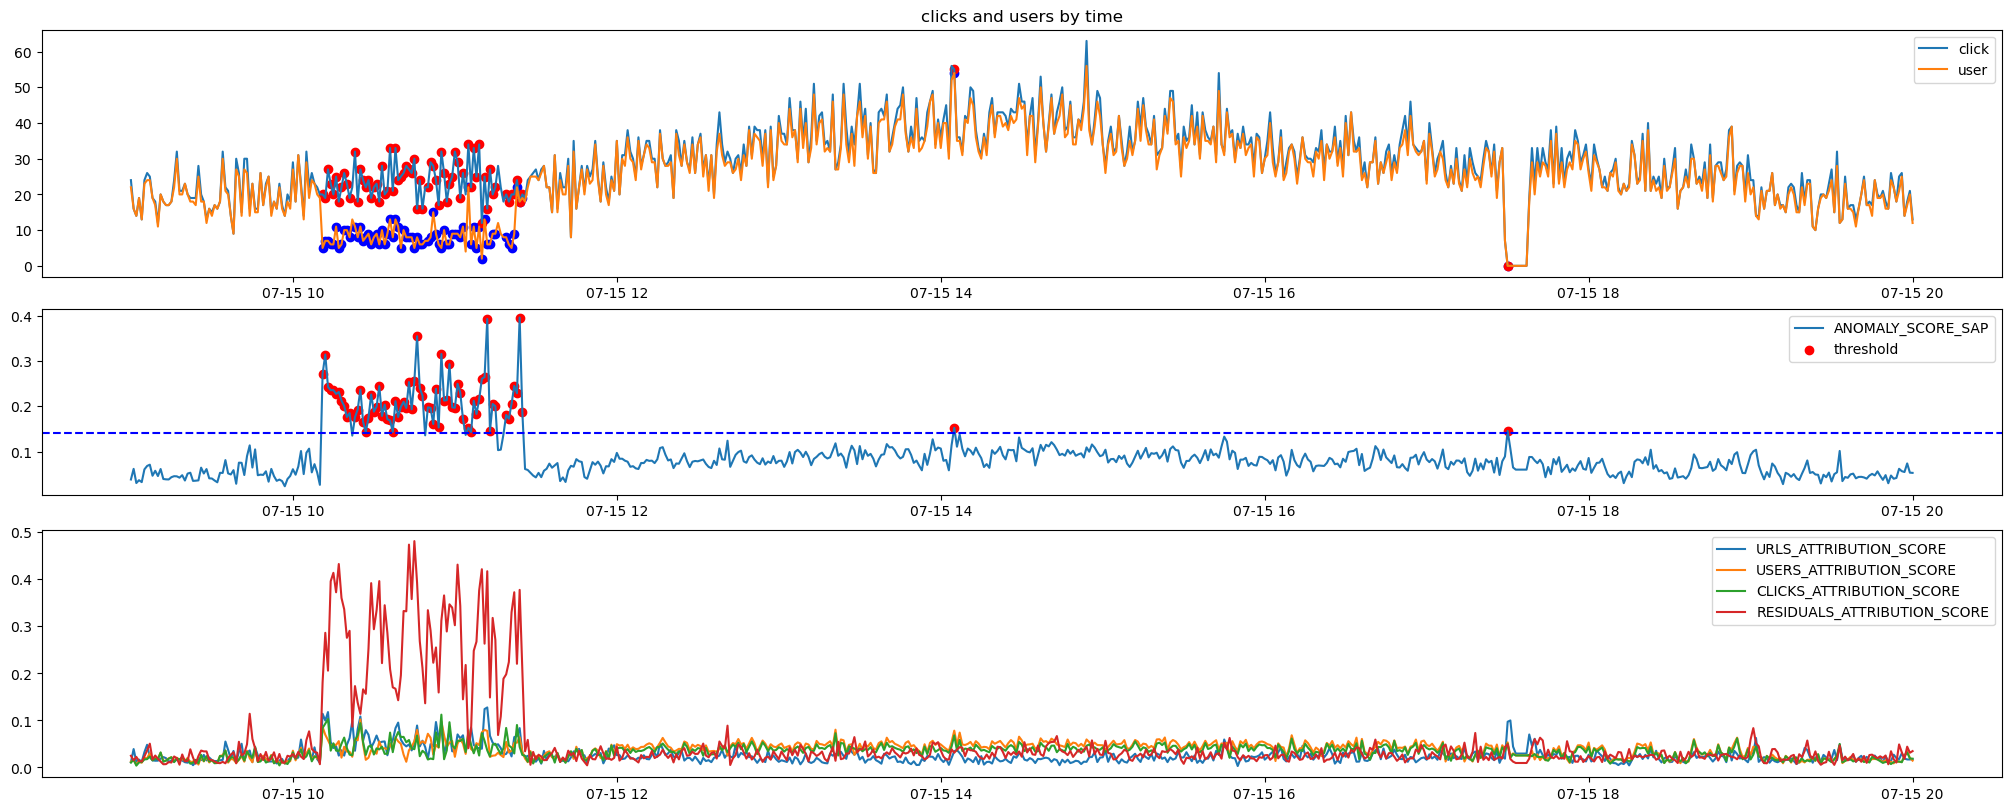

In [135]:
plot_click_w_ad_exp(pdScores, anomalous, threshold_sap, start_dt=stime, end_dt=etime, score="ANOMALY_SCORE_SAP")

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


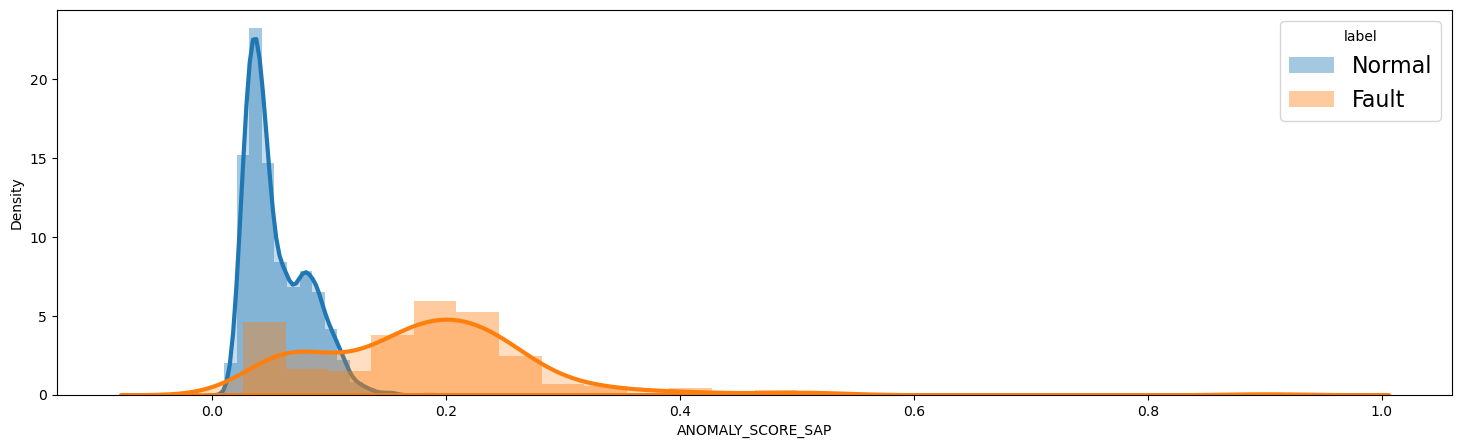

In [136]:
plt.figure(figsize = (18,5))
fault_types = [0, 1]
for fault_type in fault_types:
    
    if fault_type == 0: label = "Normal"
    else: label = "Fault"
    sns.distplot(
        pdScores[pdScores.fault==fault_type]["ANOMALY_SCORE_SAP"],
        hist=True,
        kde=True,
        kde_kws={"shade":True, "linewidth":3},
        label=label
    )
plt.legend(prop={"size":16}, title = "label")

In [137]:
precision = pdScores.query("fault == 1 and ANOMALY_SCORE_SAP > @threshold_sap").shape[0] / pdScores.query("ANOMALY_SCORE_SAP > @threshold_sap").shape[0]
recall = pdScores.query("fault == 1 and ANOMALY_SCORE_SAP > @threshold_sap").shape[0] / pdScores.query("fault == 1").shape[0]
f1_score = 2*(precision*recall)/(precision+recall)

In [138]:
print (f'Precision: {precision}')
print (f'Recall: {recall}')
print (f'f1_score: {f1_score}')

Precision: 0.7567567567567568
Recall: 0.6896551724137931
f1_score: 0.7216494845360825


In [ ]:
                #print ("anomal_score", anomal_score, anomal_score.size())
                
#                 y_bool=y.bool().flatten()
#                 falult_indices = y_bool.nonzero()
#                 normal_indices = torch.where(y_bool == False)[0]
                
#                 fault_score = anomal_score.take(falult_indices).sum()
#                 normal_score = anomal_score.take(normal_indices).sum()
                
#                 total_falut_scores += fault_score
#                 total_normal_scores += normal_score
#                 total_falut_cnt += falult_indices.size(0)
#                 total_normal_cnt += normal_indices.size(0)
                
#                 anomal_scores.append(anomal_score.sum(1).flatten().cpu().numpy())